<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter3ImageEstimation/patternSubstitutionAndNeuralFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pattern Substitution and Neural Features
### David J. Brady
### University of Arizona

### Section 3.6 of **Computational Optical Imaging**



This notebook contains a simple example of pattern substitution using matched filtering and a simple example of features extracted by a neural classifier.

## Libraries

In [51]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d, convolve
from skimage import color, data, restoration, exposure
from skimage import io
from google.colab import files
from scipy.special import expit
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size': 16})

## Pattern Substitution Example

We use matched filtering to find positions of a sad face in a background image. The match filtered image is fed into a sigmoidal activation function to identify the match positons. The activation function image is then convolved with a smile image to produce images of smiley faces at the positions of the sad faces, which are added to the image. The sad faces are subtracted using convolution with the activation image (feature map).

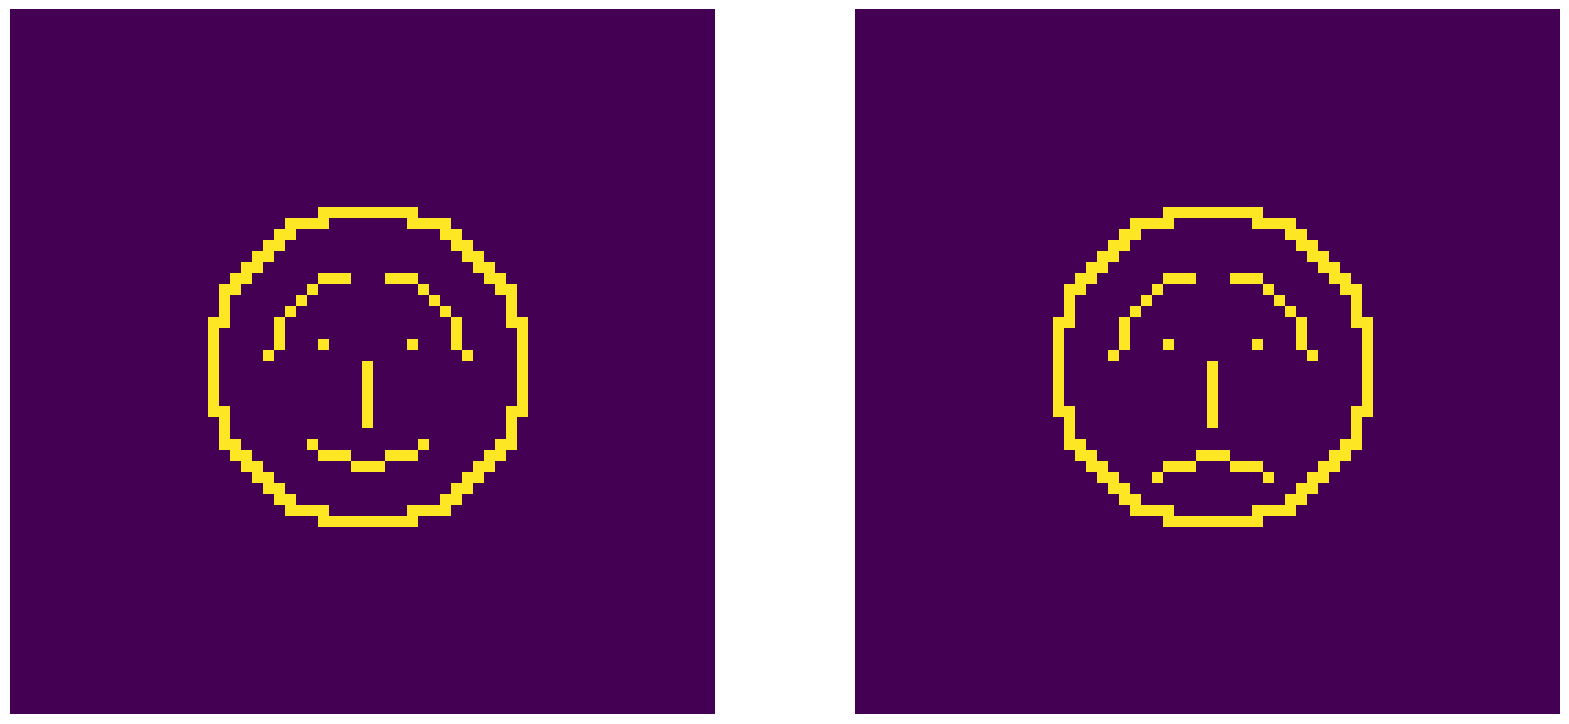

In [ ]:
# target images
face=np.zeros((64,64))
for i in range(1,64):
    for j in range(1,64):
        if np.abs((i-64/2)**2+(j-64/2)**2-200)<20:
            face[i,j]=1;
        elif np.abs((i-64/2)**2+(j-64/2)**2-75)<10 & i<25:
            face[i,j]=1;
face[30,28]=1;
face[30,36]=1;
face[32:38,32]=1;
smile=face[38:44,26:40]
frown=np.flip(smile,axis=0)
sadFace=np.zeros(np.shape(face))
sadFace=sadFace+face;
sadFace[38:44,26:40]=frown;
ig, ax = plt.subplots(nrows=1, ncols=2)
for a in (ax[0], ax[1]):
       a.axis('off')

ax[0].imshow(face)

ax[1].imshow(sadFace)

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

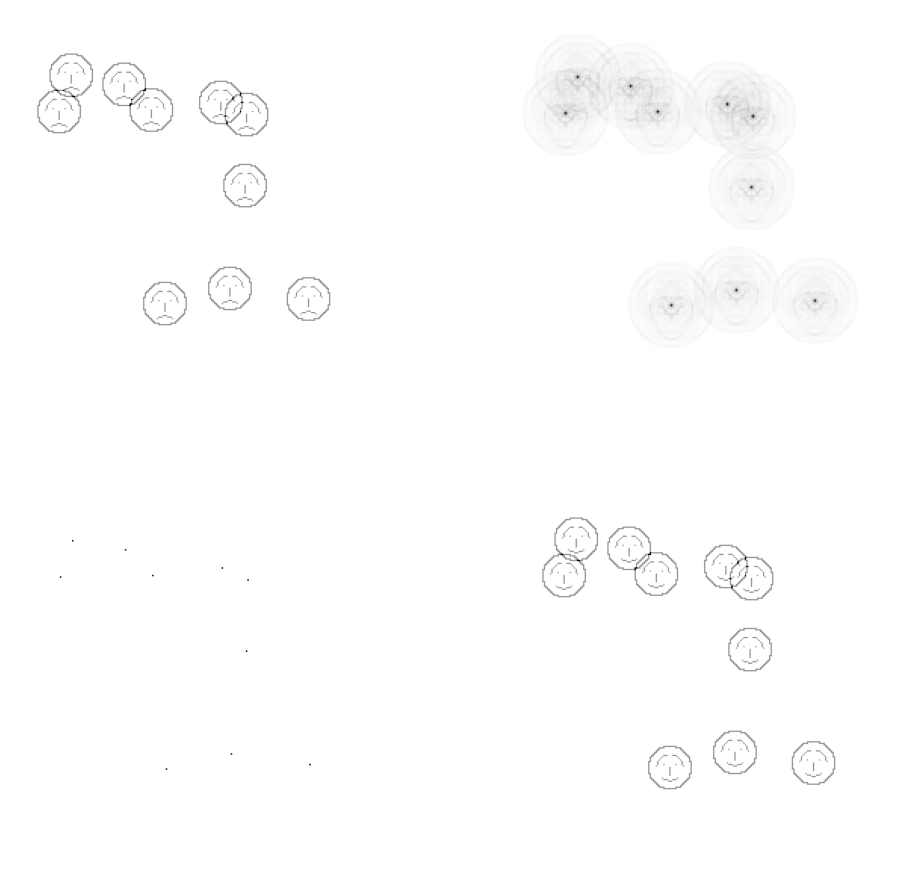

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2)
plt.rcParams['figure.figsize'] = [10, 10]
plt.gray()

for a in (ax[0,0], ax[0,1], ax[1,0], ax[1,1]):
       a.axis('off')



#
# now we add  faces to the image
#
#
x=np.random.choice(range(32,222),size=10,replace=False)
y=np.random.choice(range(32,222),size=10,replace=False)
sImage=np.zeros((256,256))
for pip in range(10):
  sImage[(x[pip]-32):(x[pip]+32),(y[pip]-32):(y[pip]+32)]=sImage[(x[pip]-32):(x[pip]+32),(y[pip]-32):(y[pip]+32)]+0.25*sadFace
ax[0,0].imshow(sImage,cmap='Greys')
#
# we use matched filtering to find the faces.
#
match=convolve2d(sImage,sadFace, mode='same')
ax[0,1].imshow(match,cmap='Greys')
#
# now we use an activation function to find the matches
#
featureMap=expit(10*(match-.8*np.max(match)))
ax[1,0].imshow(featureMap,cmap='binary')
#
# now replace the frowns with smiles
#
substitution=sImage+.25*convolve2d(np.roll(featureMap,(-2,-2),axis=(0,1)),face-sadFace,mode='same')
ax[1,1].imshow(substitution,cmap='Greys')
fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.savefig('faces.pdf')
files.download('faces.pdf')


## Classification of the MNIST digits

Here we use an AI generated classification network to classify the MNIST digits. We look a the filter functions and the layer outputs to see what features the network is identifying.

In [21]:
# prompt: load the mnist dataset for training and testing

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


11490434/11490434 [==============================] - 0s 0us/step


In [22]:
# prompt: create a neural network for classifying digits on the mnist dataset

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the data to fit the model
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Define the model
model = keras.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)


Epoch 1/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.1548 - accuracy: 0.9532
Epoch 2/5
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0506 - accuracy: 0.9845
Epoch 3/5
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0366 - accuracy: 0.9885
Epoch 4/5
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0282 - accuracy: 0.9912
Epoch 5/5
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0221 - accuracy: 0.9930
313/313 - 3s - loss: 0.0344 - accuracy: 0.9884 - 3s/epoch - 9ms/step

Test accuracy: 0.9883999824523926


In [38]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0186 - accuracy: 0.9942
Epoch 2/5
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0140 - accuracy: 0.9955
Epoch 3/5
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0115 - accuracy: 0.9962
Epoch 4/5
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0102 - accuracy: 0.9966
Epoch 5/5
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0077 - accuracy: 0.9976


In [39]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 5s - loss: 0.0342 - accuracy: 0.9907 - 5s/epoch - 16ms/step

Test accuracy: 0.9907000064849854


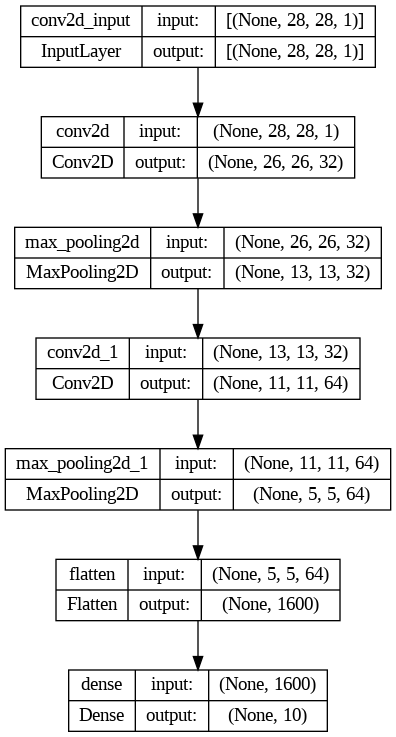

In [ ]:
# prompt: create a visualization of the network model

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


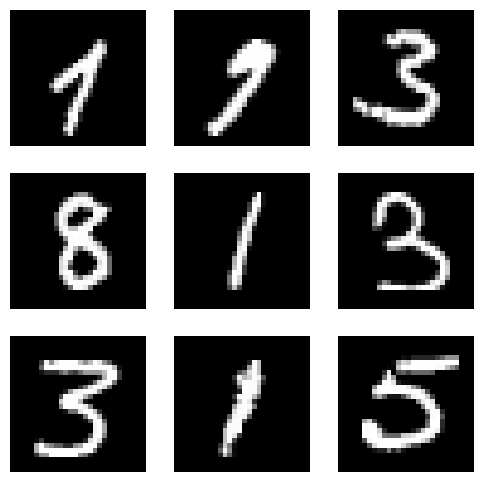

In [ ]:
# prompt: show a random selection of 9 of the MNIST digits

import matplotlib.pyplot as plt
import numpy as np
# Select a random sample of 9 digits
indices = np.random.choice(x_train.shape[0], size=9, replace=False)
images = x_train[indices]

# Display the images
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.show()


1/1 [==============================] - 0s 85ms/step


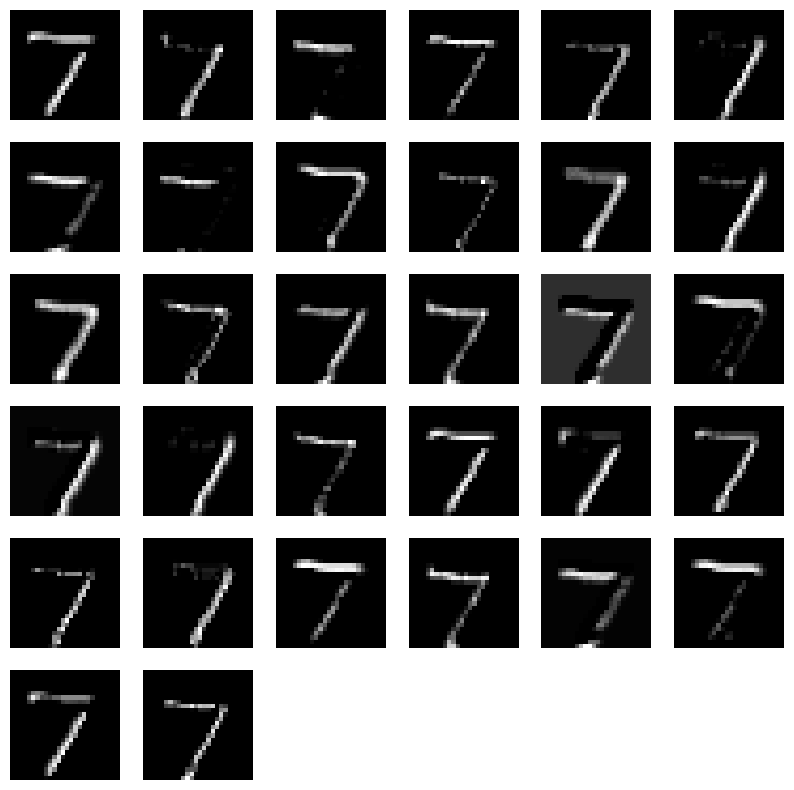

In [ ]:
# prompt: visualize the feature maps generated in the network for a particular input

# Extract the outputs of the first convolutional layer
layer_output = model.layers[0].output

# Create a new model that outputs the feature maps
activation_model = Model(inputs=model.input, outputs=layer_output)

# Choose an input image from the test set
img = x_test[0]

# Reshape the image to fit the model
img = img.reshape(1, 28, 28, 1)

# Get the feature maps for the chosen image
activations = activation_model.predict(img)

# Visualize the feature maps
plt.figure(figsize=(10, 10))
for i in range(32):
  plt.subplot(6, 6, i + 1)
  plt.imshow(activations[0, :, :, i], cmap='gray')
  plt.axis('off')
plt.show()


1/1 [==============================] - 0s 50ms/step


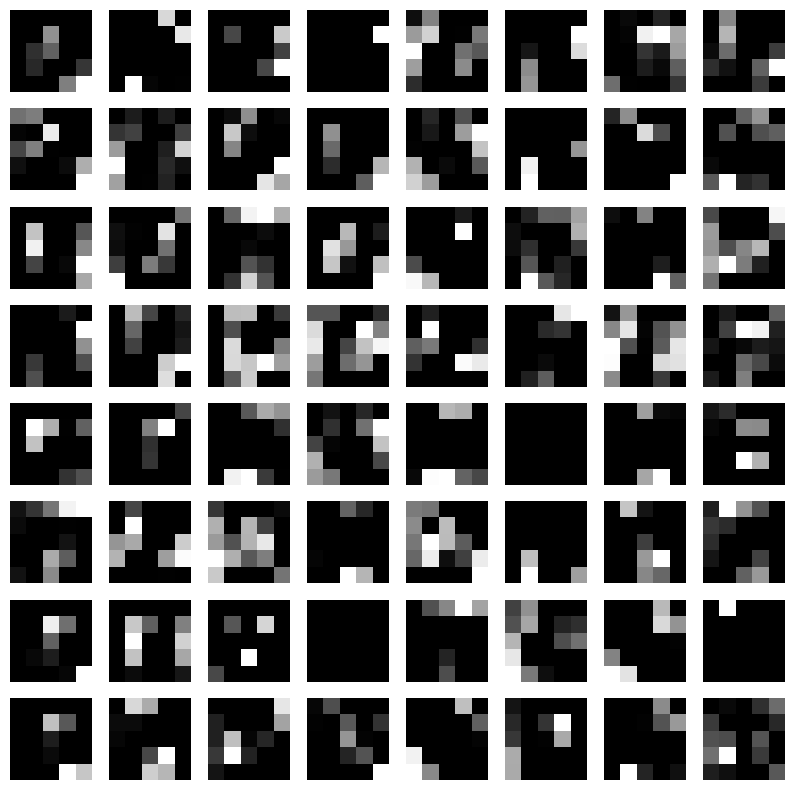

In [ ]:
# prompt: visualize the feature maps generated in the network for a particular input

# Extract the outputs of the third convolutional layer
layer_output = model.layers[3].output

# Create a new model that outputs the feature maps
activation_model = Model(inputs=model.input, outputs=layer_output)

# Choose an input image from the test set
img = x_test[10]

# Reshape the image to fit the model
img = img.reshape(1, 28, 28, 1)

# Get the feature maps for the chosen image
activations = activation_model.predict(img)
# Visualize the feature maps
plt.figure(figsize=(10, 10))
for i in range(64):
  plt.subplot(8, 8, i + 1)
  plt.imshow(activations[0, :, :, i], cmap='gray')
  plt.axis('off')
plt.show()



In [ ]:
activations.shape

(1, 5, 5, 64)

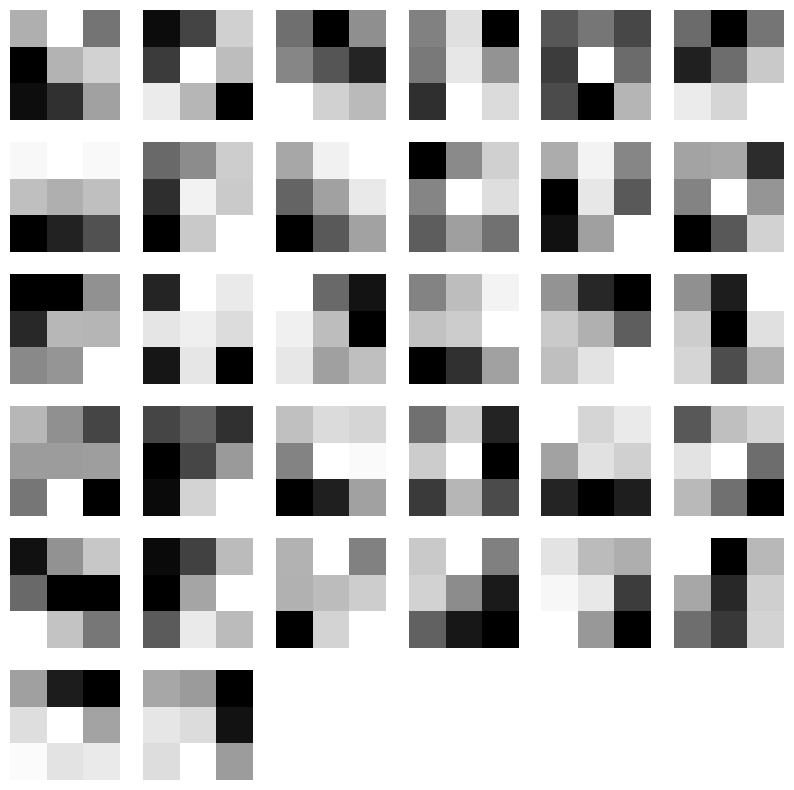

In [ ]:
# prompt: show the filter functions in the first layer of the network

import matplotlib.pyplot as plt
# Extract the weights of the first convolutional layer
filters = model.layers[0].get_weights()[0]

# Visualize the filters
plt.figure(figsize=(10, 10))
for i in range(32):
  plt.subplot(6, 6, i + 1)
  plt.imshow(filters[:,:,0,i], cmap='gray')
  plt.axis('off')
plt.show()


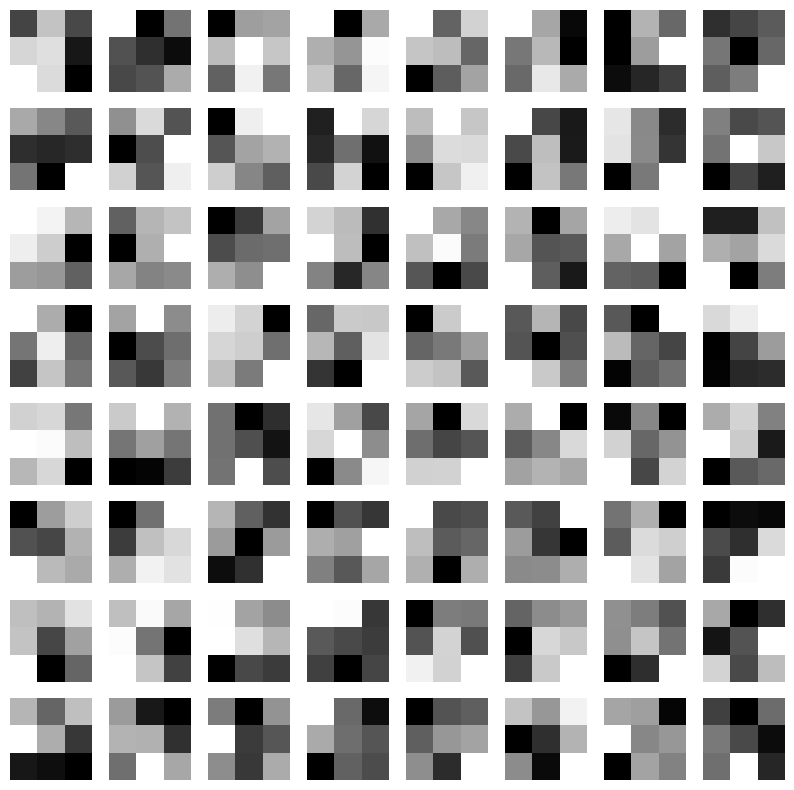

In [ ]:
# prompt: show the filter functions in the third layer of the network

import matplotlib.pyplot as plt
# Extract the weights of the third convolutional layer
filters = model.layers[2].get_weights()[0]

# Visualize the filters
plt.figure(figsize=(10, 10))
for i in range(64):
  plt.subplot(8, 8, i + 1)
  plt.imshow(filters[:,:,0,i], cmap='gray')
  plt.axis('off')
plt.show()


1/1 [==============================] - 0s 83ms/step


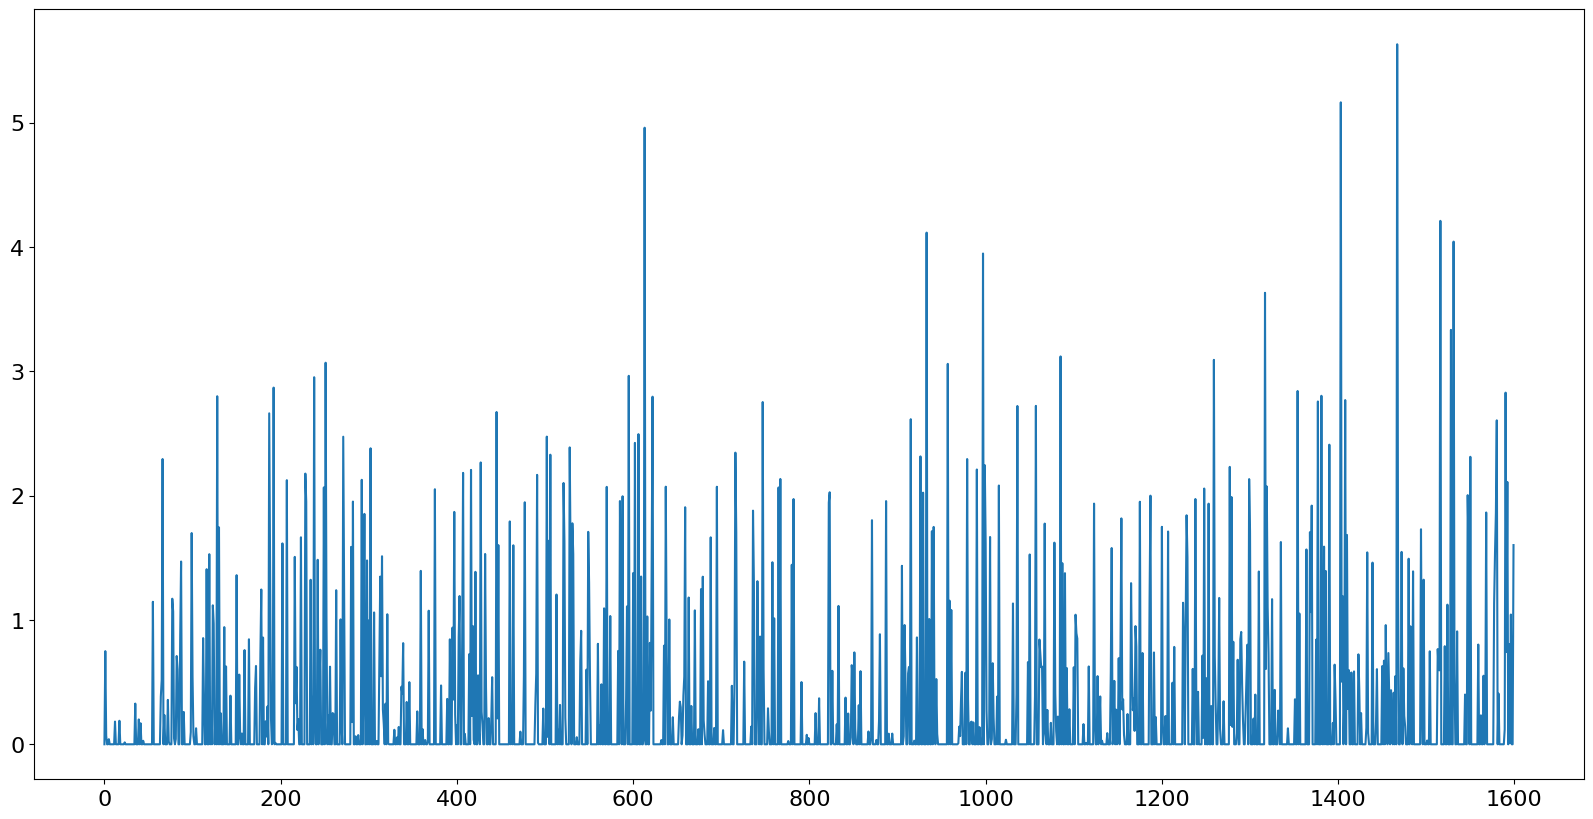

In [ ]:
# Extract the outputs of the third convolutional layer
layer_output = model.layers[4].output

# Create a new model that outputs the feature maps
activation_model = Model(inputs=model.input, outputs=layer_output)

# Choose an input image from the test set
img = x_test[10]

# Reshape the image to fit the model
img = img.reshape(1, 28, 28, 1)

# Get the feature maps for the chosen image
activations = activation_model.predict(img)
# Visualize the feature maps
plt.plot(activations[0])

1/1 [==============================] - 0s 22ms/step


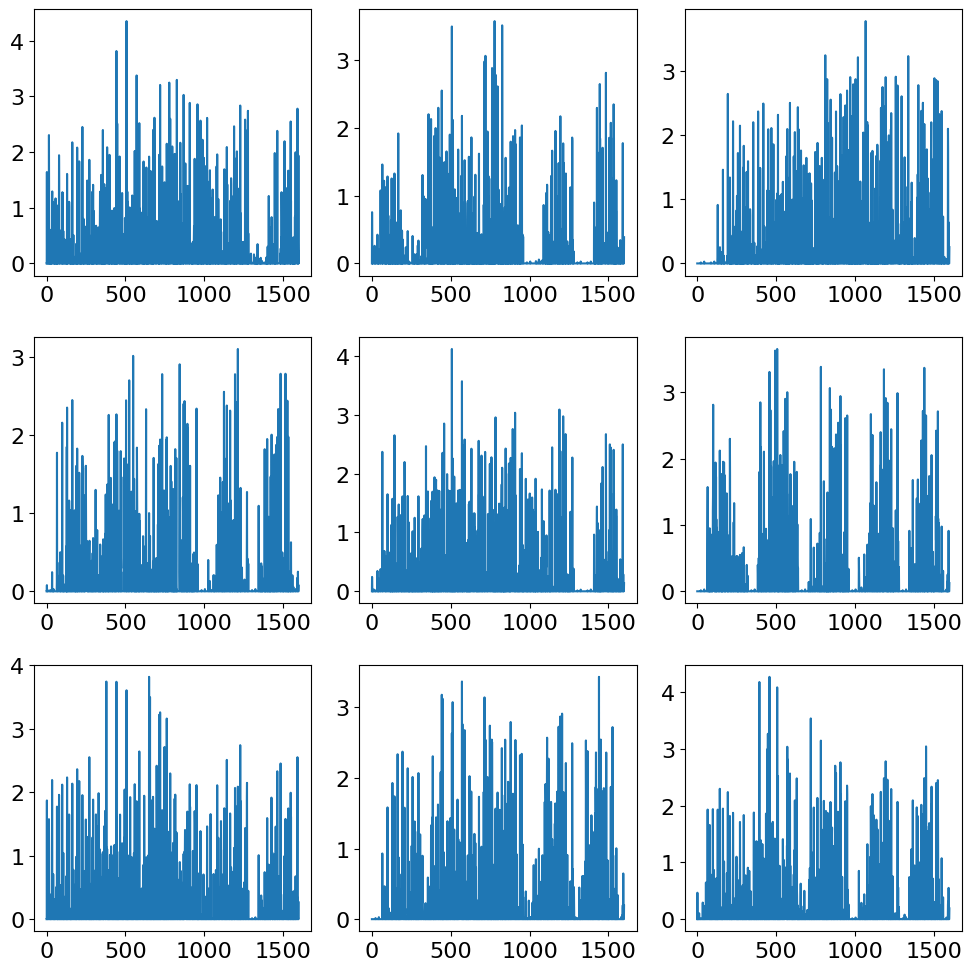

In [ ]:
# prompt: select a set of 9 mnist digits representing 7 and make a grid of plots of activations[0] for these examples


# Find indices of images representing the digit 7
indices_7 = np.where(y_test == 7)[0]

# Select a random sample of 9 images representing the digit 7
indices = np.random.choice(indices_7, size=9, replace=False)
images_7 = x_test[indices]

# Plot the activations for the selected images
plt.figure(figsize=(10, 10))
for i in range(9):
  img = images_7[i].reshape(1, 28, 28, 1)
  activations = activation_model.predict(img)
  plt.subplot(3, 3, i + 1)
  plt.plot(activations[0])
  #plt.title('Digit 7')
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 37ms/step


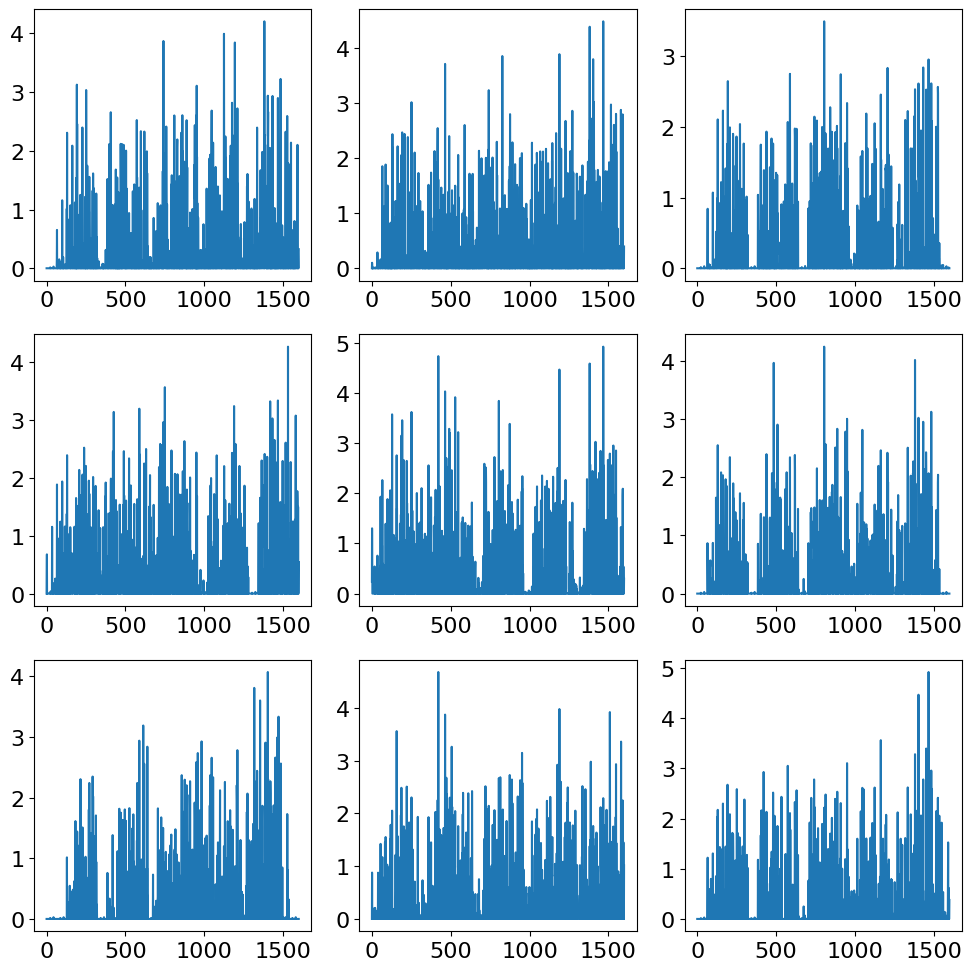

In [ ]:
# prompt: select a set of 9 mnist digits representing 7 and make a grid of plots of activations[0] for these examples


# Find indices of images representing the digit 7
indices_7 = np.where(y_test == 8)[0]

# Select a random sample of 9 images representing the digit 7
indices = np.random.choice(indices_7, size=9, replace=False)
images_7 = x_test[indices]

# Plot the activations for the selected images
plt.figure(figsize=(10, 10))
for i in range(9):
  img = images_7[i].reshape(1, 28, 28, 1)
  activations = activation_model.predict(img)
  plt.subplot(3, 3, i + 1)
  plt.plot(activations[0])
  #plt.title('Digit 7')
plt.tight_layout()
plt.show()

In [2]:


image = cv2.imread('digits.png', cv2.IMREAD_GRAYSCALE)



In [3]:
image.shape

(302, 863)

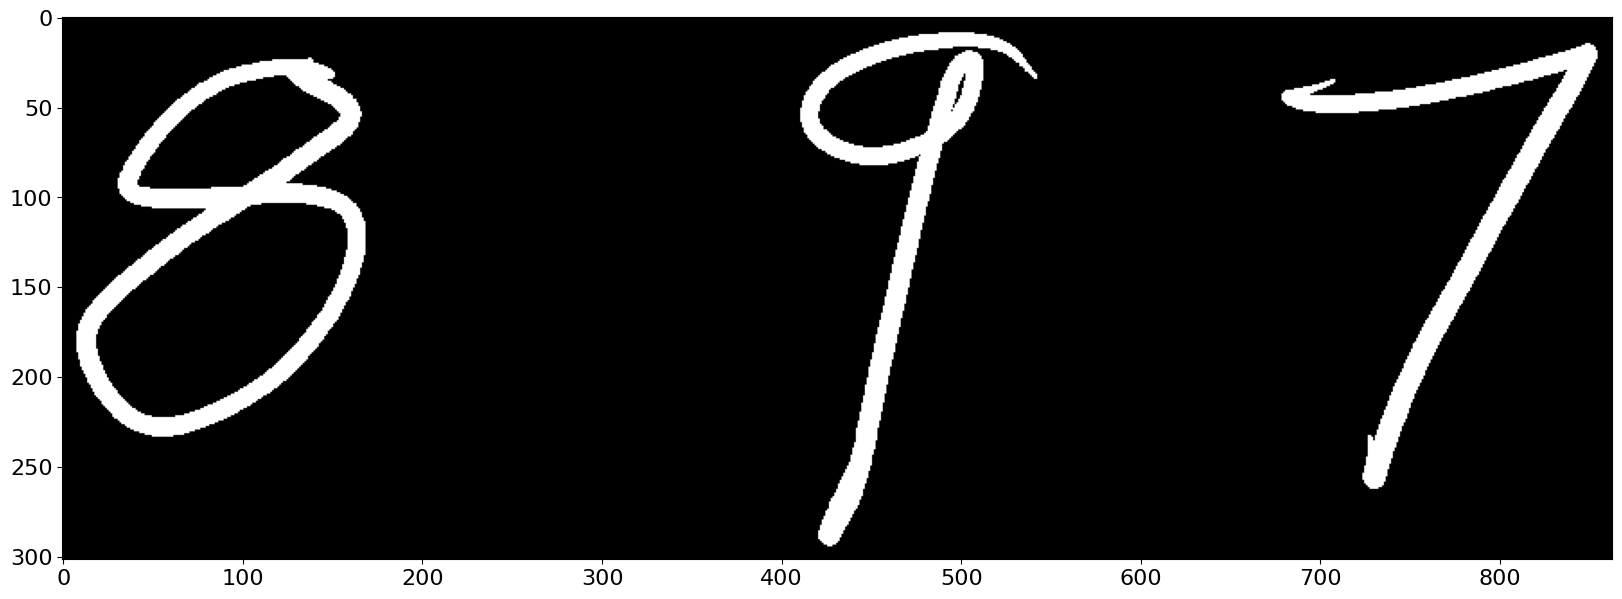

In [4]:
plt.imshow(image, cmap='gray')

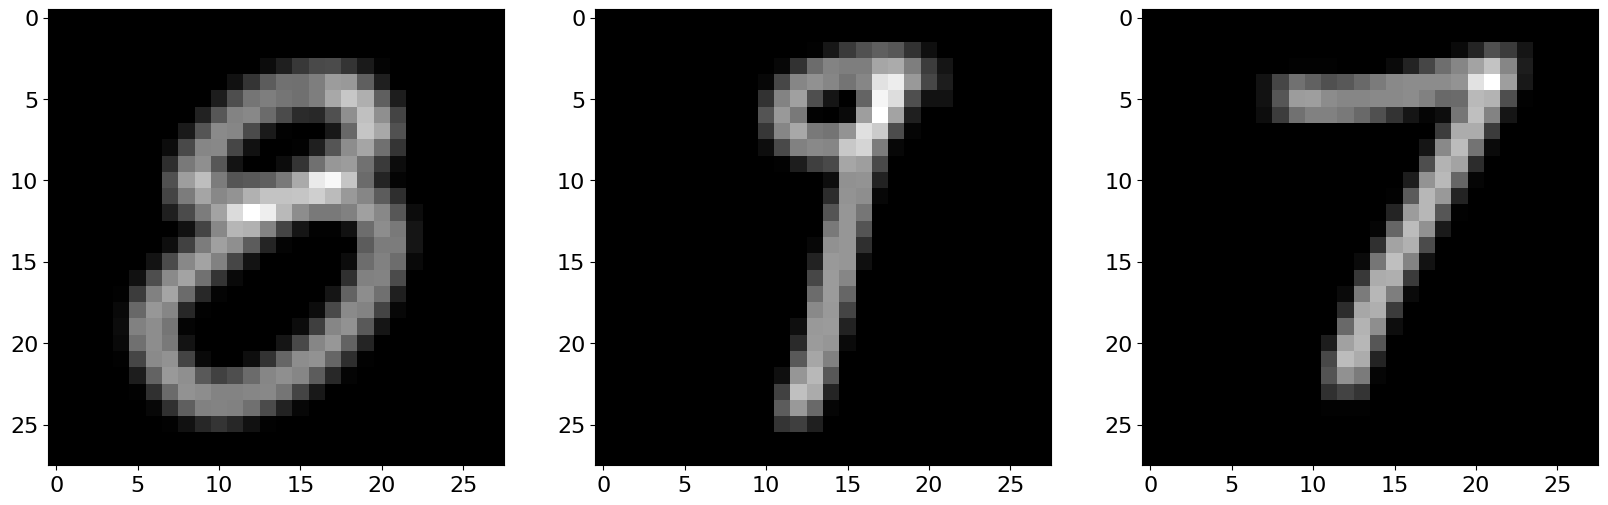

In [74]:
eight=image[0:250,0:250]
nine=image[0:300,300:600]
seven=image[0:300,563:]
eight=cv2.resize(cv2.blur(np.pad(eight,((20,20),(20,20)),'constant'),(30,30)),(28,28))
eight=eight/np.max(eight)
eight=np.roll(eight,(0,3),axis=(0,1))
nine=cv2.resize(cv2.blur(np.pad(nine,((30,30),(30,30)),'constant'),(30,30)),(28,28))
nine=nine/np.max(nine)
seven=cv2.resize(cv2.blur(np.pad(seven,((20,20),(20,20)),'constant'),(30,30)),(28,28))
seven=seven/np.max(seven)
seven=np.roll(seven,(0,-3),axis=(0,1))
plt.subplot(1,3,1)
plt.imshow(eight, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(nine, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(seven, cmap='gray')

1/1 [==============================] - 0s 22ms/step
Predicted class: 7


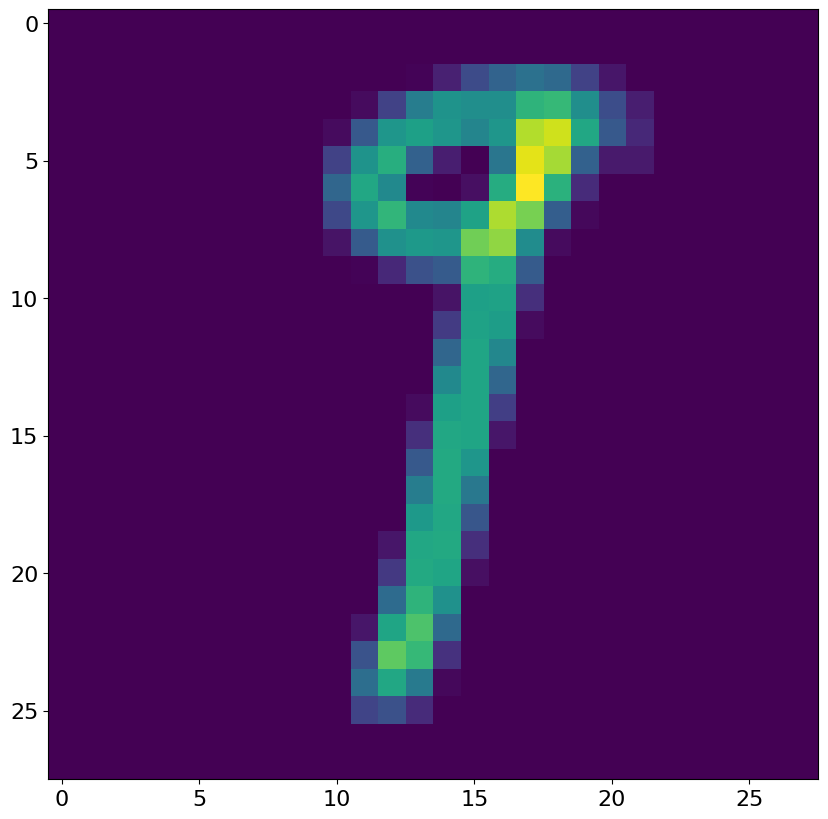

In [75]:
# prompt: classify image using the network model




# Reshape the data to fit the model
img=nine.reshape(1, 28, 28, 1)

plt.imshow(img[0,:,:,0])
# Make the prediction
prediction = model.predict(img)

# Get the predicted class
predicted_class = np.argmax(prediction)

print('Predicted class:', predicted_class)